<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
AOI: Optical Metrology of TDV Hole Height 
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>December, 2025</font></center>

***

# Import libraries

In [1]:
import os

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.interpolate import interp1d
from joblib import Parallel, delayed  
import S4

# load MATLAB colormap: parula
mat = scipy.io.loadmat("parula.mat")
parula_rgb = mat["P"]
parula_map = ListedColormap(parula_rgb)

plt.rcParams["font.family"] = "Helvetica"
# rc('text', usetex=True)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# S4 function of TDV model

In [ ]:
def R_TDV_S4(lda, spot_size, hole_height, n_SiO2, n_Si3N4, n_Si):
    """
    Define a function of S4 for calculating the reflectance of TDV model.
    Args:
        lda (float): Wavelength in micrometers
        spot_size (float): Spot size in micrometers
        hole_height (float): Height of the hole in micrometers
        n_SiO2 (float): Refractive index of SiO2
        n_Si3N4 (float): Refractive index of Si3N4
        n_Si (float): Refractive index of Si
    Returns:
        float: Reflectance of the structure
    """

    period = [spot_size, spot_size]
    S = S4.New(Lattice=((period[0], 0), (0, period[1])), NumBasis=101)

    S.SetMaterial(Name="Air", Epsilon=(1 + 0j) ** 2)
    S.SetMaterial(Name="SiO2", Epsilon=n_SiO2 ** 2)
    S.SetMaterial(Name="Si3N4", Epsilon=n_Si3N4 ** 2)
    S.SetMaterial(Name="Si", Epsilon=n_Si ** 2)

    S.AddLayer(Name="Air_layer", Thickness=0.1, Material="Air")

    ############ HM layer ############
    S.AddLayer(Name="HM_Si3N4_layer", Thickness=0.100, Material="Si3N4")
    S.SetRegionCircle(
        Layer="HM_Si3N4_layer",
        Material="Air",
        Center=(0, 0),
        Radius=1.5/2,
    )

    S.AddLayer(Name="HM_SiO2_layer", Thickness=3.400, Material="SiO2")
    S.SetRegionCircle(
        Layer="HM_SiO2_layer",
        Material="Air",
        Center=(0, 0),
        Radius=1.5/2,
    )
    ############ Film Si layer ############
    S.AddLayer(Name="Film_Si_layer", Thickness=9.000, Material="Si")
    S.SetRegionCircle(
        Layer="Film_Si_layer",
        Material="Air",
        Center=(0, 0),
        Radius=1.5/2,
    )

    ############ TDV layer ############
    mask_thickness = 12.5
    # TDV stack from top to bottom (material, thickness in micrometers)
    tdv_stack = [
        ("SiO2", 0.9),
        ("Si3N4", 0.1),
        ("SiO2", 0.9),
        ("Si3N4", 0.1),
        ("SiO2", 0.5),
        ("Si3N4", 0.1),
        ("SiO2", 0.5),
        ("Si3N4", 0.1),
        ("SiO2", 0.1),
    ]
    total_tdv_thickness = sum(thickness for _, thickness in tdv_stack)
    hole_depth_in_tdv = np.clip(hole_height - mask_thickness, 0, total_tdv_thickness)
    remaining_depth = hole_depth_in_tdv
    for layer_idx, (material, thickness) in enumerate(tdv_stack, start=1):
        base_name = f"TDV_{material}_{layer_idx}"
        if remaining_depth <= 0:
            S.AddLayer(Name=f"{base_name}_bulk", Thickness=thickness, Material=material)
            continue
        hole_segment = min(thickness, remaining_depth)
        S.AddLayer(Name=f"{base_name}_hole", Thickness=hole_segment, Material=material)
        S.SetRegionCircle(
            Layer=f"{base_name}_hole",
            Material="Air",
            Center=(0, 0),
            Radius=1.5/2,
        )
        remaining_depth = max(0.0, remaining_depth - hole_segment)
        residual_thickness = thickness - hole_segment
        if residual_thickness > 1e-6:
            S.AddLayer(
                Name=f"{base_name}_bulk",
                Thickness=residual_thickness,
                Material=material,
            )

    ############ Substrate Si  ############
    S.AddLayer(Name="Subs_layer", Thickness=0.1, Material="Si")

    S.SetExcitationPlanewave(
        IncidenceAngles=(0, 0), sAmplitude=1, pAmplitude=0, Order=0
    )
    S.SetOptions(PolarizationDecomposition=True)
    S.SetFrequency(1.0 / lda)

    powr1 = S.GetPowerFluxByOrder(Layer="Air_layer", zOffset=0)
    # powr2 = S.GetPowerFluxByOrder(Layer='Subs_layer', zOffset=0)
    R = np.abs(np.real(powr1[0][1])) / np.real(powr1[0][0])

    return R

## Indices of SiO2, Si3N4, and Si

In [3]:
# Load refractive index data for SiO2
data_sio2 = np.loadtxt("indices/sio2.txt", delimiter="\t", skiprows=1)

lda_sio2 = data_sio2[:, 0] * 1e-3
n_sio2 = data_sio2[:, 1]
k_sio2 = data_sio2[:, 2]

n_sio2_interp = interp1d(lda_sio2, n_sio2, kind="linear")
k_sio2_interp = interp1d(lda_sio2, k_sio2, kind="linear")

# Load refractive index data for Si3N4
data_si3n4 = np.loadtxt("indices/si3n4.txt", delimiter="\t", skiprows=1)

lda_si3n4 = data_si3n4[:, 0] * 1e-3
n_si3n4 = data_si3n4[:, 1]
k_si3n4 = data_si3n4[:, 2]

n_si3n4_interp = interp1d(lda_si3n4, n_si3n4, kind="linear")
k_si3n4_interp = interp1d(lda_si3n4, k_si3n4, kind="linear")

# Load refractive index data for Si
data_si = np.loadtxt("indices/si.txt", delimiter="\t", skiprows=1)

lda_si = data_si[:, 0] * 1e-3
n_si = data_si[:, 1]
k_si = data_si[:, 2]

n_si_interp = interp1d(lda_si, n_si, kind="linear")
k_si_interp = interp1d(lda_si, k_si, kind="linear")

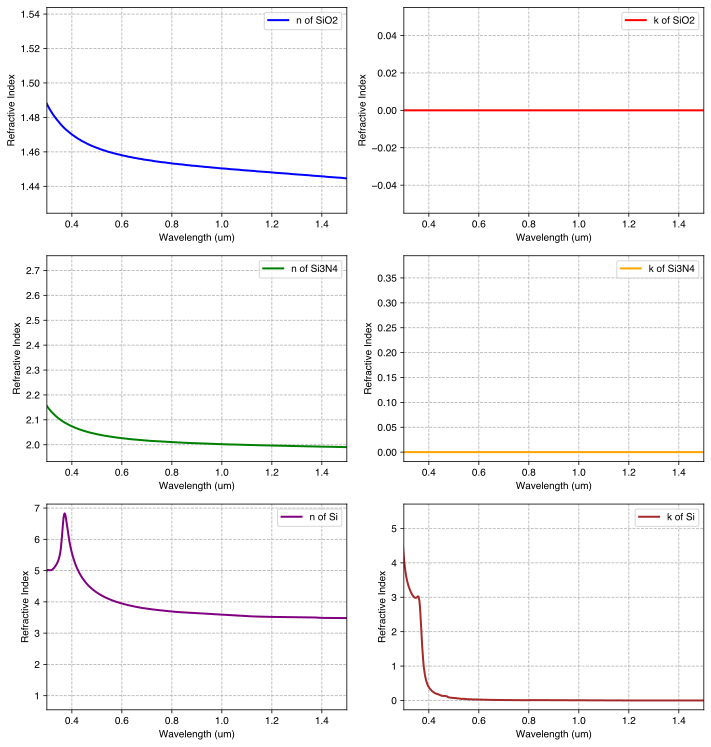

In [4]:
# Plot the reflection of the materials
materials = [
    ("SiO2", lda_sio2, n_sio2, k_sio2, ("blue", "red")),
    ("Si3N4", lda_si3n4, n_si3n4, k_si3n4, ("green", "orange")),
    ("Si", lda_si, n_si, k_si, ("purple", "brown")),
]
fig, ax = plt.subplots(len(materials), 2, figsize=(10, 10.5))

for row_idx, (name, lda, n_arr, k_arr, colors) in enumerate(materials):
    ax[row_idx][0].plot(lda, n_arr, color=colors[0], lw=2, label=f"n of {name}")
    ax[row_idx][1].plot(lda, k_arr, color=colors[1], lw=2, label=f"k of {name}")
    for col_idx in range(2):
        ax[row_idx][col_idx].set_xlabel("Wavelength (um)")
        ax[row_idx][col_idx].set_ylabel("Refractive Index")
        ax[row_idx][col_idx].set_xlim(0.3, 1.5)
        ax[row_idx][col_idx].grid(linestyle="--")
        ax[row_idx][col_idx].legend(loc=1)

fig.tight_layout()

## R spectra of different air holes

In [5]:
spot_size = 4.0 # in micrometers
hole_height = 12.5  # in micrometers

lda_space = np.linspace(0.3, 1.5, 1201)  # Wavelengths from 0.3 to 1.5 micrometers

In [6]:
n_jobs = os.cpu_count()
print(f"Running with {n_jobs} parallel workers...")

Running with 10 parallel workers...


In [7]:
def _tdv_reflectance_at_lambda(lda_value):
    n_sio2_val = n_sio2_interp(lda_value)+1j*k_sio2_interp(lda_value)
    n_si3n4_val = n_si3n4_interp(lda_value)+1j*k_si3n4_interp(lda_value)
    n_si_val = n_si_interp(lda_value)+1j*k_si_interp(lda_value)
    return R_TDV_S4(
        lda_value,
        spot_size,
        hole_height,
        n_sio2_val,
        n_si3n4_val,
        n_si_val,
    )

RSpace = np.array(
    Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_tdv_reflectance_at_lambda)(lda_value) for lda_value in lda_space
    )
)

Plot R spectrum

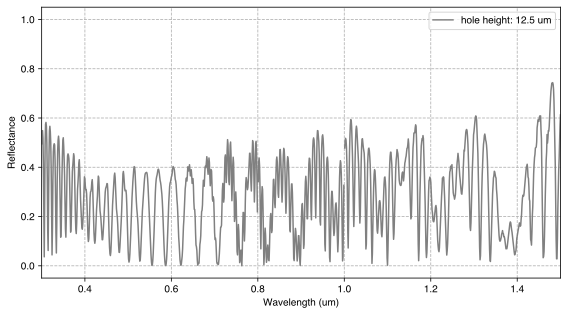

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
ax.plot(lda_space, RSpace, color="gray", lw=1.5, label=f"hole height: {hole_height} um")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Reflectance")
ax.set_xlim(0.3, 1.5)
ax.set_ylim(-0.05, 1.05)
ax.grid(linestyle="--")
ax.legend(loc=1)

fig.tight_layout()